In [ ]:
!pip uninstall -y findspark
!pip install pyspark -q


Found existing installation: findspark 2.0.1
Uninstalling findspark-2.0.1:
  Successfully uninstalled findspark-2.0.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("SentimentAnalysisProject") \
    .config("spark.ui.showConsoleProgress", "false") \
    .getOrCreate()

spark


In [ ]:
data_path = '/content/drive/MyDrive/BDA Project Dataset/Cell_Phones_and_Accessories.json'

df = spark.read.json(data_path)

df.printSchema()
df.show(10, truncate=False)


root
 |-- asin: string (nullable = true)
 |-- image: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- overall: double (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- reviewTime: string (nullable = true)
 |-- reviewerID: string (nullable = true)
 |-- reviewerName: string (nullable = true)
 |-- style: struct (nullable = true)
 |    |-- Color Name:: string (nullable = true)
 |    |-- Color:: string (nullable = true)
 |    |-- Design:: string (nullable = true)
 |    |-- Edition:: string (nullable = true)
 |    |-- Flavor Name:: string (nullable = true)
 |    |-- Flavor:: string (nullable = true)
 |    |-- Format:: string (nullable = true)
 |    |-- Hand Orientation:: string (nullable = true)
 |    |-- Item Display Length:: string (nullable = true)
 |    |-- Item Package Quantity:: string (nullable = true)
 |    |-- Length:: string (nullable = true)
 |    |-- Material Type:: string (nullable = true)
 |    |-- Material:: string (nullable = true)
 

1. Preprocessing


In [ ]:

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lower, regexp_replace, concat_ws
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF

def main():
    spark = SparkSession.builder.appName("BaseDataPrep").getOrCreate()

    # === 1. DEFINE FILE PATHS ===
    raw_json_path = '/content/drive/MyDrive/BDA Project Dataset/Cell_Phones_and_Accessories.json'
    processed_parquet_path = '/content/drive/MyDrive/BDA Project Dataset/processed_sentiment_data.parquet'

    # === 2. LOAD RAW DATA FROM DRIVE ===
    print(f"{raw_json_path}")
    df = spark.read.json(raw_json_path)

    # === 3. PREPROCESSING AND FEATURE EXTRACTION ===
    # Combine summary and reviewText, drop nulls, and create sentiment label
    # 0 = Negative (1-2 stars)
    # 1 = Neutral (3 stars)
    # 2 = Positive (4-5 stars)
    df_labeled = df.select(
        "overall",
        concat_ws(" ", col("summary"), col("reviewText")).alias("review")
    ).dropna(subset=["overall", "review"]).withColumn("sentiment",
        when(col("overall").between(1, 2), 0)
        .when(col("overall") == 3, 1)
        .otherwise(2)
    )

    # Clean text: lowercase and remove non-alphabetic characters
    df_cleaned_text = df_labeled.withColumn("review_clean", lower(regexp_replace(col("review"), "[^a-zA-Z\\s]", "")))

    # Tokenize: Split text into individual words
    tokenizer = Tokenizer(inputCol="review_clean", outputCol="words")
    df_tokenized = tokenizer.transform(df_cleaned_text)

    # Stopword Removal: Filter out common words (e.g., 'the', 'is', 'a')
    remover = StopWordsRemover(inputCol="words", outputCol="words_filtered")
    df_final = remover.transform(df_tokenized)

    # --- TF-IDF Feature Extraction ---

    # 1. HashingTF: Convert words to a numerical vector (Term Frequency)
    # numFeatures=20000 means we hash all words into 20,000 possible "buckets"
    hashingTF = HashingTF(inputCol="words_filtered", outputCol="rawFeatures", numFeatures=20000)
    df_featurized = hashingTF.transform(df_final)

    # 2. IDF: Weight the terms by importance (Inverse Document Frequency)
    idf = IDF(inputCol="rawFeatures", outputCol="features")
    idfModel = idf.fit(df_featurized)
    df_tfidf = idfModel.transform(df_featurized)

    # Final data ready for the model
    model_data = df_tfidf.select("features", col("sentiment").alias("label"))

    model_data.show(5, truncate=False)

    # === 4. SAVE PROCESSED DATA TO DRIVE ===
    print(f"{processed_parquet_path}")
    model_data.write.mode("overwrite").parquet(processed_parquet_path)

    spark.stop()

if __name__ == "__main__":
    main()


/content/drive/MyDrive/BDA Project Dataset/Cell_Phones_and_Accessories.json
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                   |label|
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://cli.github.com/packages stable InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Get:7 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:8 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,532 kB]
Fetched 3,789 kB in 2s (1,651 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' a

In [ ]:
!pip install pyspark findspark -q

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Loading pre-processed data from: /content/drive/MyDrive/BDA Project Dataset/processed_sentiment_data.parquet
Data loaded successfully.
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|features                                                                                                                                                                                                                                                                                                                                                                   |label|
+------------------------------------------------------------------------------------------------------------------------

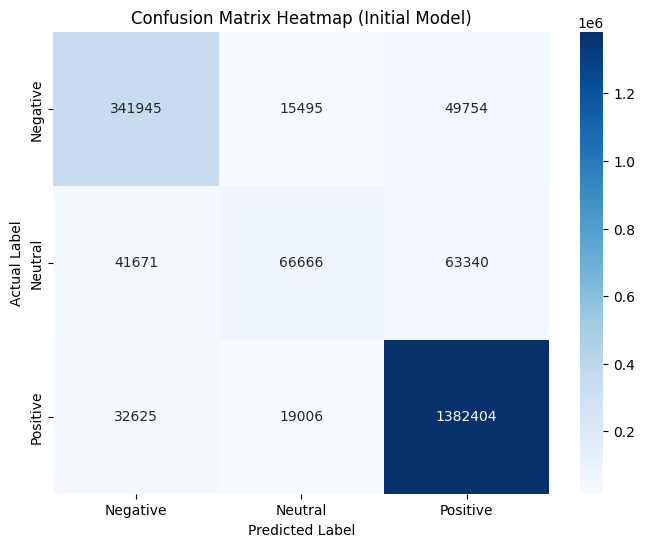

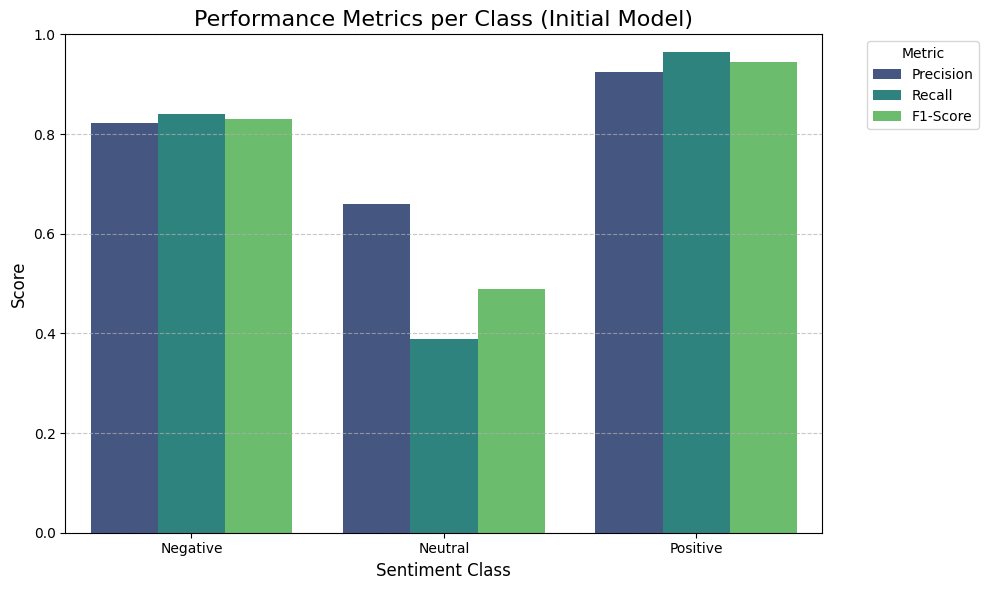

Smallest class (Neutral) count: 688933
Total rows: 2068898
F1 Score (Balanced Model): 0.86
+-----+----------+-------+
|label|prediction|  count|
+-----+----------+-------+
|    0|       0.0| 332164|
|    0|       1.0|  61163|
|    0|       2.0|  13867|
|    1|       0.0|  30464|
|    1|       1.0| 120390|
|    1|       2.0|  20823|
|    2|       0.0|  46357|
|    2|       1.0| 147500|
|    2|       2.0|1240178|
+-----+----------+-------+



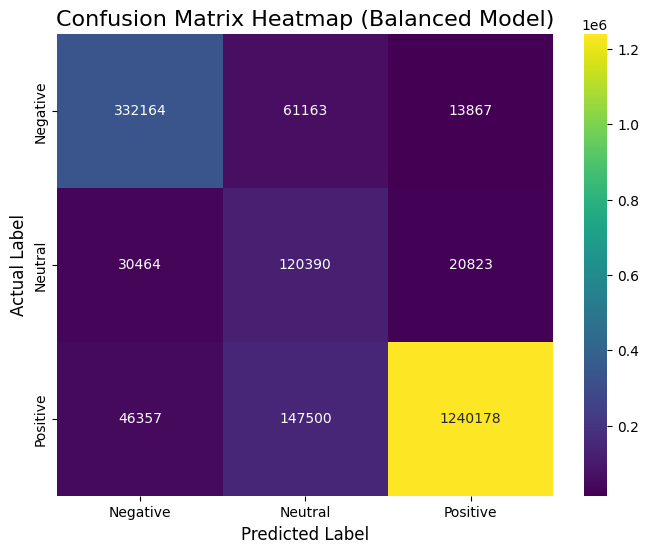

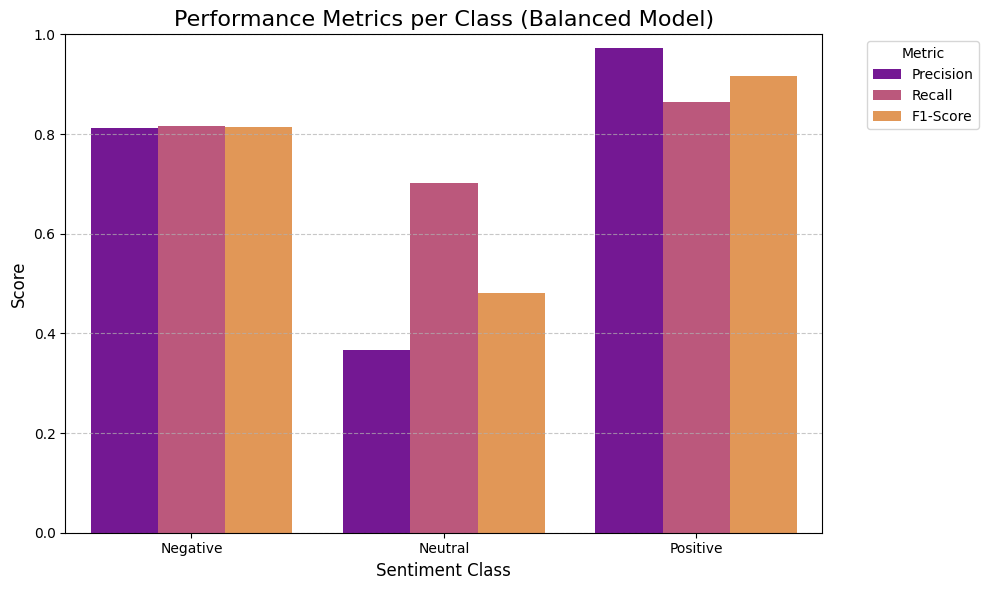


--- Full Analysis Complete ---


In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def main():
    spark = SparkSession.builder.appName("SentimentModeling").getOrCreate()

    # === 1. LOAD THE PRE-PROCESSED DATA ===
    processed_parquet_path = '/content/drive/MyDrive/BDA Project Dataset/processed_sentiment_data.parquet'
    print(f"Loading pre-processed data from: {processed_parquet_path}")
    model_data = spark.read.parquet(processed_parquet_path)
    print("Data loaded successfully.")

    # --- Verify Data ---
    model_data.show(5, truncate=False)
    total_rows = model_data.count()
    print(f"Total Rows:  {total_rows}")


    # === 2. INITIAL MODEL ===

    # --- 2.1. Split and Train ---
    (trainingData, testData) = model_data.randomSplit([0.8, 0.2], seed=42)

    lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
    lrModel = lr.fit(trainingData)

    # --- 2.2. Make Predictions & Evaluate ---
    predictions = lrModel.transform(testData)

    predictions.select("label", "prediction").show(5)

    evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

    accuracy = evaluator.setMetricName("accuracy").evaluate(predictions)
    f1_score = evaluator.setMetricName("f1").evaluate(predictions)

    print(f"Accuracy (Initial Model): {accuracy:.2f}")
    print(f"F1 Score (Initial Model): {f1_score:.2f}")

    confusion_matrix_df = predictions.groupBy("label", "prediction").count().orderBy("label", "prediction")
    confusion_matrix_df.show()

    # --- 2.3. Visualize Initial Model Results ---

    # Convert the Spark DataFrame confusion matrix to a Pandas DataFrame
    confusion_matrix_pd = confusion_matrix_df.toPandas()
    class_names = ['Negative', 'Neutral', 'Positive']

    # Pivot the table for the heatmap
    try:
        confusion_matrix_pivot = confusion_matrix_pd.pivot_table(index="label", columns="prediction", values="count").fillna(0)
        # Ensure all 3x3 cells exist
        for i in range(3):
            if i not in confusion_matrix_pivot.index:
                confusion_matrix_pivot.loc[i] = 0
            if i not in confusion_matrix_pivot.columns:
                confusion_matrix_pivot[i] = 0

        # Plot 1: Confusion Matrix Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix_pivot, annot=True, fmt=".0f", cmap="Blues",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix Heatmap (Initial Model)')
        plt.ylabel('Actual Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Plot 2: Per-Class Performance Metrics
        TP = [confusion_matrix_pivot.loc[i, i] for i in range(3)]
        FP = [confusion_matrix_pivot.sum(axis=0)[i] - TP[i] for i in range(3)]
        FN = [confusion_matrix_pivot.sum(axis=1)[i] - TP[i] for i in range(3)]

        precision = [TP[i] / (TP[i] + FP[i]) if (TP[i] + FP[i]) > 0 else 0 for i in range(3)]
        recall = [TP[i] / (TP[i] + FN[i]) if (TP[i] + FN[i]) > 0 else 0 for i in range(3)]
        class_f1_score = [2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0 for i in range(3)]

        metrics_df = pd.DataFrame({
            'Class': class_names * 3,
            'Metric': ['Precision'] * 3 + ['Recall'] * 3 + ['F1-Score'] * 3,
            'Score': precision + recall + class_f1_score
        })

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_df, palette='viridis',
                    order=['Negative', 'Neutral', 'Positive'])
        plt.title('Performance Metrics per Class (Initial Model)', fontsize=16)
        plt.xlabel('Sentiment Class', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during visualization: {e}")


    # === 3. BALANCED MODEL (UNDERSAMPLING) ===


    # --- 3.1. Create the Balanced Training Data ---
    df_neg = trainingData.filter(trainingData['label'] == 0).cache()
    df_neu = trainingData.filter(trainingData['label'] == 1).cache()
    df_pos = trainingData.filter(trainingData['label'] == 2).cache()

    # Find the size of the smallest class (Neutral)
    smallest_class_count = df_neu.count()
    print(f"Smallest class (Neutral) count: {smallest_class_count}")

    # Calculate sampling fractions
    neg_fraction = smallest_class_count / df_neg.count()
    pos_fraction = smallest_class_count / df_pos.count()

    # Sample the majority classes down
    df_neg_sampled = df_neg.sample(withReplacement=False, fraction=neg_fraction, seed=42)
    df_pos_sampled = df_pos.sample(withReplacement=False, fraction=pos_fraction, seed=42)

    # Combine the three balanced classes
    balanced_trainingData = df_neg_sampled.unionAll(df_neu).unionAll(df_pos_sampled)

    print(f"Total rows: {balanced_trainingData.count()}")

    # --- 3.2. Train the Model on Balanced Data ---
    lr_balanced = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
    lr_balanced_Model = lr_balanced.fit(balanced_trainingData)

    # --- 3.3. Make and Evaluate Predictions (on the original unbalanced testData) ---
    predictions_balanced = lr_balanced_Model.transform(testData)

    f1_balanced = evaluator.setMetricName("f1").evaluate(predictions_balanced)
    print(f"F1 Score (Balanced Model): {f1_balanced:.2f}")

    confusion_matrix_balanced_df = predictions_balanced.groupBy("label", "prediction").count().orderBy("label", "prediction")
    confusion_matrix_balanced_df.show()

    # --- 3.4. Visualize Balanced Model Results ---

    # Convert to Pandas
    confusion_matrix_balanced_pd = confusion_matrix_balanced_df.toPandas()

    try:
        # Pivot the table for the heatmap
        confusion_matrix_balanced_pivot = confusion_matrix_balanced_pd.pivot_table(index="label", columns="prediction", values="count").fillna(0)
        # Ensure all 3x3 cells exist
        for i in range(3):
            if i not in confusion_matrix_balanced_pivot.index:
                confusion_matrix_balanced_pivot.loc[i] = 0
            if i not in confusion_matrix_balanced_pivot.columns:
                confusion_matrix_balanced_pivot[i] = 0

        # Plot 1: Confusion Matrix Heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(confusion_matrix_balanced_pivot, annot=True, fmt=".0f", cmap="viridis",
                    xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix Heatmap (Balanced Model)', fontsize=16)
        plt.ylabel('Actual Label', fontsize=12)
        plt.xlabel('Predicted Label', fontsize=12)
        plt.show()

        # Plot 2: Per-Class Performance Metrics
        TP_b = [confusion_matrix_balanced_pivot.loc[i, i] for i in range(3)]
        FP_b = [confusion_matrix_balanced_pivot.sum(axis=0)[i] - TP_b[i] for i in range(3)]
        FN_b = [confusion_matrix_balanced_pivot.sum(axis=1)[i] - TP_b[i] for i in range(3)]

        precision_b = [TP_b[i] / (TP_b[i] + FP_b[i]) if (TP_b[i] + FP_b[i]) > 0 else 0 for i in range(3)]
        recall_b = [TP_b[i] / (TP_b[i] + FN_b[i]) if (TP_b[i] + FN_b[i]) > 0 else 0 for i in range(3)]
        class_f1_score_b = [2 * (precision_b[i] * recall_b[i]) / (precision_b[i] + recall_b[i]) if (precision_b[i] + recall_b[i]) > 0 else 0 for i in range(3)]

        metrics_df_b = pd.DataFrame({
            'Class': class_names * 3,
            'Metric': ['Precision'] * 3 + ['Recall'] * 3 + ['F1-Score'] * 3,
            'Score': precision_b + recall_b + class_f1_score_b
        })

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Class', y='Score', hue='Metric', data=metrics_df_b, palette='plasma',
                    order=['Negative', 'Neutral', 'Positive'])
        plt.title('Performance Metrics per Class (Balanced Model)', fontsize=16)
        plt.xlabel('Sentiment Class', fontsize=12)
        plt.ylabel('Score', fontsize=12)
        plt.ylim(0, 1)
        plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"An error occurred during balanced visualization: {e}")

    # Clean up cache
    df_neg.unpersist()
    df_neu.unpersist()
    df_pos.unpersist()

    print("\n--- Full Analysis Complete ---")
    spark.stop()

if __name__ == "__main__":
    main()